### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
random_seed = 59
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Read Dataset

In [ ]:
dataset_path = 'Data/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


#### Preprocess

In [8]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

In [11]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_seed,
    shuffle=is_shuffle
)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(273, 9)
(79, 9)
(40, 9)


In [12]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

### Create PyTorch DataLoader

In [13]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [64]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Build MLP Network

In [65]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.output(x)
        return x.squeeze(1)

In [66]:
input_dim = X_train.shape[1]
output_dim = 1
hidden_dim = 64

model = MLP(input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim).to(device)

In [67]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [68]:
def r_squared(y, y_pred):
    y = torch.Tensor(y).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    y_mean = torch.mean(y)
    ss_tot = torch.sum((y - y_mean) ** 2)
    ss_res = torch.sum((y - y_pred) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

### Train

In [69]:
epochs = 100
train_losses, val_losses, train_r2, val_r2 = [], [], [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, val_target, train_predict, val_predict = [], [], [], []

    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.extend(y_pred.tolist())
        train_target.extend(y_batch.tolist())
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict).item())
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            val_loss += loss.item()
            val_predict.extend(y_pred.tolist())
            val_target.extend(y_batch.tolist())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict).item())
    
    print(f'Epoch {epoch + 1}/{epochs}:\ttrain_loss: {train_loss:.3f}\tval_loss: {val_loss:.3f}')

Epoch 1/100:	train_loss: 388.472	val_loss: 164.167
Epoch 2/100:	train_loss: 194.265	val_loss: 163.130
Epoch 3/100:	train_loss: 57.540	val_loss: 19.982
Epoch 4/100:	train_loss: 71.312	val_loss: 10.959
Epoch 5/100:	train_loss: 17.026	val_loss: 8.720
Epoch 6/100:	train_loss: 12.285	val_loss: 9.896
Epoch 7/100:	train_loss: 12.783	val_loss: 7.798
Epoch 8/100:	train_loss: 12.507	val_loss: 13.393
Epoch 9/100:	train_loss: 17.332	val_loss: 8.162
Epoch 10/100:	train_loss: 9.003	val_loss: 33.777
Epoch 11/100:	train_loss: 17.064	val_loss: 9.202
Epoch 12/100:	train_loss: 15.109	val_loss: 8.712
Epoch 13/100:	train_loss: 16.260	val_loss: 41.367
Epoch 14/100:	train_loss: 17.994	val_loss: 5.206
Epoch 15/100:	train_loss: 13.145	val_loss: 14.904
Epoch 16/100:	train_loss: 9.570	val_loss: 5.795
Epoch 17/100:	train_loss: 9.309	val_loss: 7.863
Epoch 18/100:	train_loss: 12.569	val_loss: 12.021
Epoch 19/100:	train_loss: 9.132	val_loss: 8.269
Epoch 20/100:	train_loss: 11.022	val_loss: 6.146
Epoch 21/100:	train_

### Evaluation

In [70]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_r2 = r_squared(y_test, y_pred)
    print(f'Test R2: {test_r2:.3f}')

Test R2: 0.849


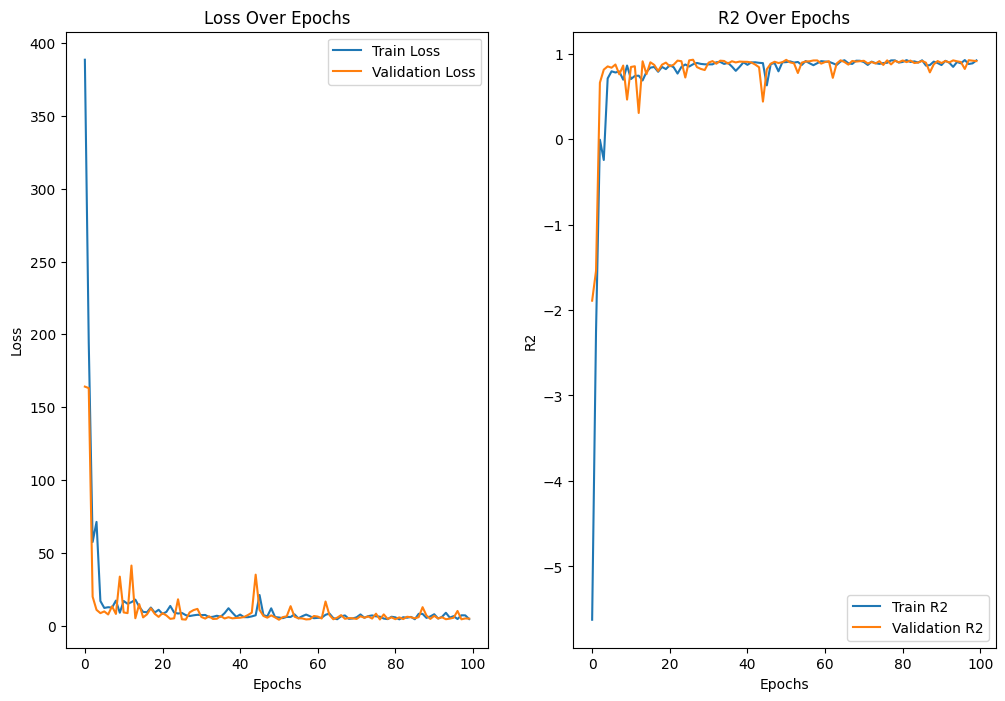

In [73]:
# Plot those loss and r2 on 2x2 plot
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_r2, label='Train R2')
plt.plot(val_r2, label='Validation R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()
plt.title('R2 Over Epochs')
plt.show()
